## An Ensemble Deep Learning Model for Vehicular Engine Health Prediction

In [1]:
#import the libraries
import pandas as pd
import numpy  as np
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, SimpleRNN

In [2]:
#read the dataset
df = pd.read_csv('engine_data.csv')

In [3]:
#read the read
df.head()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Engine Condition
0,700,2.493592,11.790927,3.178981,84.144163,81.632187,1
1,876,2.941606,16.193866,2.464504,77.640934,82.445724,0
2,520,2.961746,6.553147,1.064347,77.752266,79.645777,1
3,473,3.707835,19.510172,3.727455,74.129907,71.774629,1
4,619,5.672919,15.738871,2.052251,78.396989,87.000225,0


In [4]:
#information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19535 entries, 0 to 19534
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Engine rpm        19535 non-null  int64  
 1   Lub oil pressure  19535 non-null  float64
 2   Fuel pressure     19535 non-null  float64
 3   Coolant pressure  19535 non-null  float64
 4   lub oil temp      19535 non-null  float64
 5   Coolant temp      19535 non-null  float64
 6   Engine Condition  19535 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 1.0 MB


#### No null values in the dataset, and no data types which are in object, directly use them in training phase.

In [5]:
#check the values in target column
df['Engine Condition'].value_counts()

Engine Condition
1    12317
0     7218
Name: count, dtype: int64

#### 0 indicates Bad condition and 1 indicates Good contidion

In [6]:
#Calculating the Correlation Coefficient
corr_matrix = df.corr()
corr_matrix["Engine Condition"].sort_values(ascending=False)

Engine Condition    1.000000
Fuel pressure       0.116259
Lub oil pressure    0.060904
Coolant pressure   -0.024054
Coolant temp       -0.046326
lub oil temp       -0.093635
Engine rpm         -0.268201
Name: Engine Condition, dtype: float64

#### Engine Condition has the highest positive correlation with Fuel Pressure
#### Engine Condition has the highest negative correlation with Engine RPM

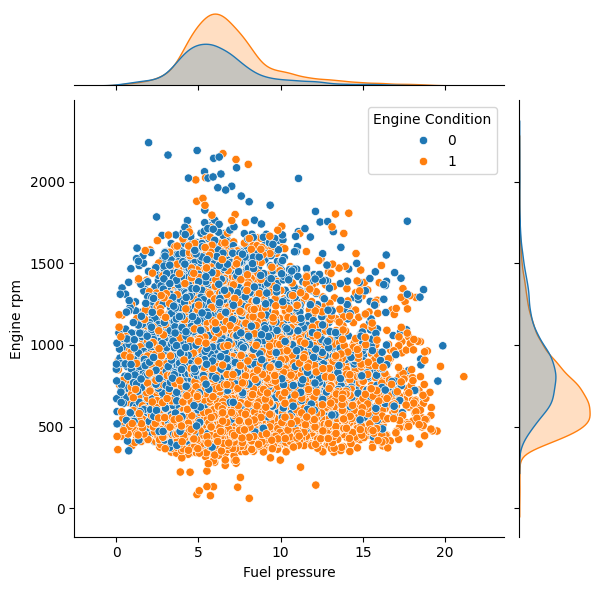

In [7]:
sns.jointplot(df, x="Fuel pressure", y="Engine rpm", hue="Engine Condition")

In [8]:
df_rounded = df.round(2)

In [9]:
# renaming the column as enginecondition
df_rounded = df_rounded.rename(columns={'Engine Condition': 'enginecondition'})

In [10]:
df_rounded.head()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,enginecondition
0,700,2.49,11.79,3.18,84.14,81.63,1
1,876,2.94,16.19,2.46,77.64,82.45,0
2,520,2.96,6.55,1.06,77.75,79.65,1
3,473,3.71,19.51,3.73,74.13,71.77,1
4,619,5.67,15.74,2.05,78.40,87.00,0


In [11]:
#spit the data
X = df_rounded.drop("enginecondition",axis=1)
y = df_rounded['enginecondition']

In [12]:
#check the shape of data
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (19535, 6)
Shape of y: (19535,)


In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [100]:
# Training individual models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [101]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [102]:
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [103]:
# Predictions and accuracy
y_pred_rf = rf_model.predict(X_test)
y_pred_dt = dt_model.predict(X_test)
y_pred_svm = svm_model.predict(X_test)

# Calculating accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

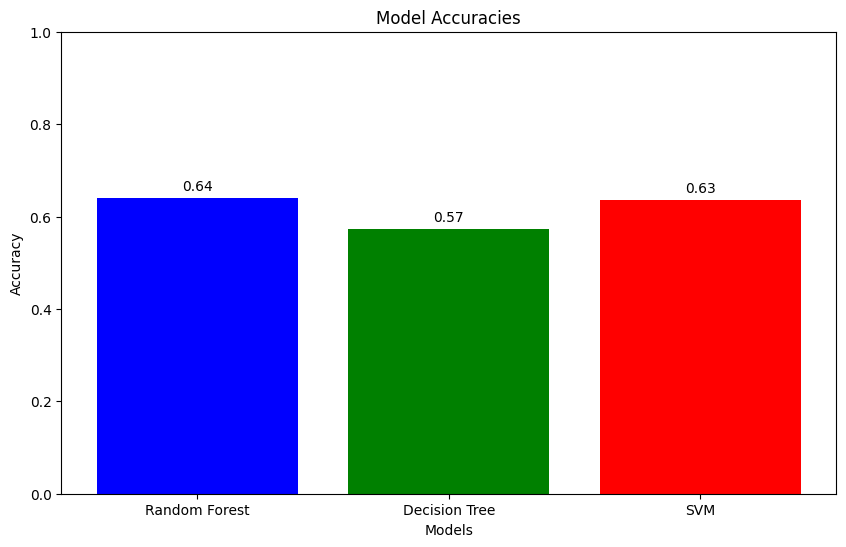

In [104]:
# Plotting accuracy of individual models
models = ['Random Forest', 'Decision Tree', 'SVM']
accuracies = [accuracy_rf, accuracy_dt, accuracy_svm]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')
plt.show()

In [105]:

# Normalizing the data
normalizer = MinMaxScaler()
X_train_normalized = normalizer.fit_transform(X_train)
X_test_normalized = normalizer.transform(X_test)

# Reshaping the data for CNN
X_train_cnn_normalized = X_train_normalized.reshape(X_train_normalized.shape[0], X_train_normalized.shape[1], 1)
X_test_cnn_normalized = X_test_normalized.reshape(X_test_normalized.shape[0], X_test_normalized.shape[1], 1)


In [106]:
# LSTM Model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_normalized.shape[1], 1)),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_normalized, y_train, epochs=60, batch_size=32)

Epoch 1/60
489/489 [==============================] - 3s 3ms/step - loss: 0.6609 - accuracy: 0.6294
Epoch 2/60
489/489 [==============================] - 1s 3ms/step - loss: 0.6321 - accuracy: 0.6396
Epoch 3/60
489/489 [==============================] - 1s 3ms/step - loss: 0.6162 - accuracy: 0.6499
Epoch 4/60
489/489 [==============================] - 2s 3ms/step - loss: 0.6119 - accuracy: 0.6573
Epoch 5/60
489/489 [==============================] - 1s 3ms/step - loss: 0.6126 - accuracy: 0.6540
Epoch 6/60
489/489 [==============================] - 1s 3ms/step - loss: 0.6096 - accuracy: 0.6551
Epoch 7/60
489/489 [==============================] - 1s 3ms/step - loss: 0.6109 - accuracy: 0.6552
Epoch 8/60
489/489 [==============================] - 2s 3ms/step - loss: 0.6087 - accuracy: 0.6593
Epoch 9/60
489/489 [==============================] - 1s 3ms/step - loss: 0.6080 - accuracy: 0.6621
Epoch 10/60
489/489 [==============================] - 1s 3ms/step - loss: 0.6075 - accuracy: 0.6614

In [107]:
# CNN Model
cnn_model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X_train_cnn_normalized.shape[1], 1)),
    MaxPooling1D(2),
    Flatten(),
    Dense(1, activation='sigmoid')
])
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train_cnn_normalized, y_train, epochs=10, batch_size=32)

Epoch 1/10
489/489 [==============================] - 2s 2ms/step - loss: 0.6552 - accuracy: 0.6315
Epoch 2/10
489/489 [==============================] - 1s 2ms/step - loss: 0.6365 - accuracy: 0.6348
Epoch 3/10
489/489 [==============================] - 1s 2ms/step - loss: 0.6230 - accuracy: 0.6477
Epoch 4/10
489/489 [==============================] - 1s 2ms/step - loss: 0.6156 - accuracy: 0.6582
Epoch 5/10
489/489 [==============================] - 1s 2ms/step - loss: 0.6117 - accuracy: 0.6589
Epoch 6/10
489/489 [==============================] - 1s 2ms/step - loss: 0.6090 - accuracy: 0.6620
Epoch 7/10
489/489 [==============================] - 1s 2ms/step - loss: 0.6076 - accuracy: 0.6643
Epoch 8/10
489/489 [==============================] - 1s 2ms/step - loss: 0.6066 - accuracy: 0.6625
Epoch 9/10
489/489 [==============================] - 1s 2ms/step - loss: 0.6056 - accuracy: 0.6634
Epoch 10/10
489/489 [==============================] - 1s 2ms/step - loss: 0.6049 - accuracy: 0.6641

In [108]:
# RNN Model
rnn_model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(X_train_normalized.shape[1], 1)),
    Dense(1, activation='sigmoid')
])
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
rnn_model.fit(X_train_normalized, y_train, epochs=10, batch_size=32)

Epoch 1/10
489/489 [==============================] - 2s 2ms/step - loss: 0.6318 - accuracy: 0.6492
Epoch 2/10
489/489 [==============================] - 1s 2ms/step - loss: 0.6078 - accuracy: 0.6643
Epoch 3/10
489/489 [==============================] - 1s 2ms/step - loss: 0.6061 - accuracy: 0.6625
Epoch 4/10
489/489 [==============================] - 1s 2ms/step - loss: 0.6042 - accuracy: 0.6653
Epoch 5/10
489/489 [==============================] - 1s 2ms/step - loss: 0.6026 - accuracy: 0.6691
Epoch 6/10
489/489 [==============================] - 1s 2ms/step - loss: 0.6018 - accuracy: 0.6682
Epoch 7/10
489/489 [==============================] - 1s 2ms/step - loss: 0.6010 - accuracy: 0.6676
Epoch 8/10
489/489 [==============================] - 1s 2ms/step - loss: 0.5998 - accuracy: 0.6707
Epoch 9/10
489/489 [==============================] - 1s 2ms/step - loss: 0.5995 - accuracy: 0.6694
Epoch 10/10
489/489 [==============================] - 1s 2ms/step - loss: 0.5995 - accuracy: 0.6686

Accuracy is saturated it is ranging from 65 to 68%.

No matter how much you tune the algorithm the accucary will not increase because of outliers in the data.

Check the outlier distribution in below graph.

We need to treat the outlier in this case.


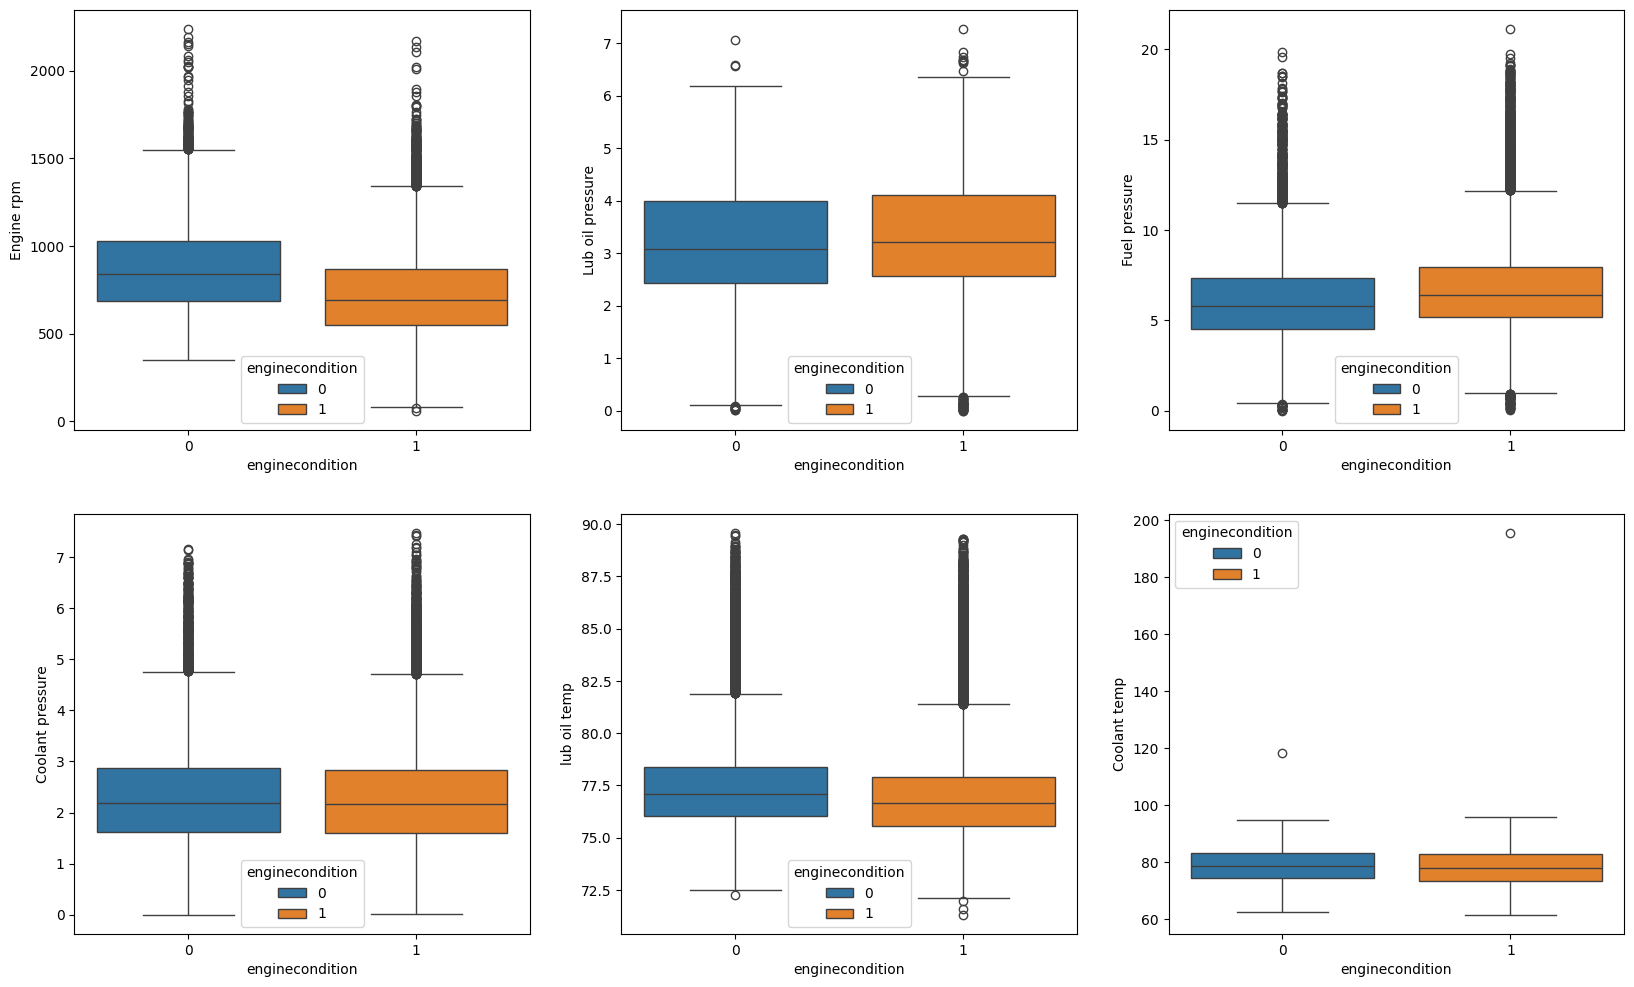

In [110]:
plt.figure(figsize = (20,12))
list_columns =  df.columns[0:6].tolist()
for index, col_name in enumerate(list_columns):
    plt.subplot(2,3,index+1)
    sns.boxplot(y = col_name , x= 'enginecondition', hue='enginecondition', data=df_rounded)
plt.show()

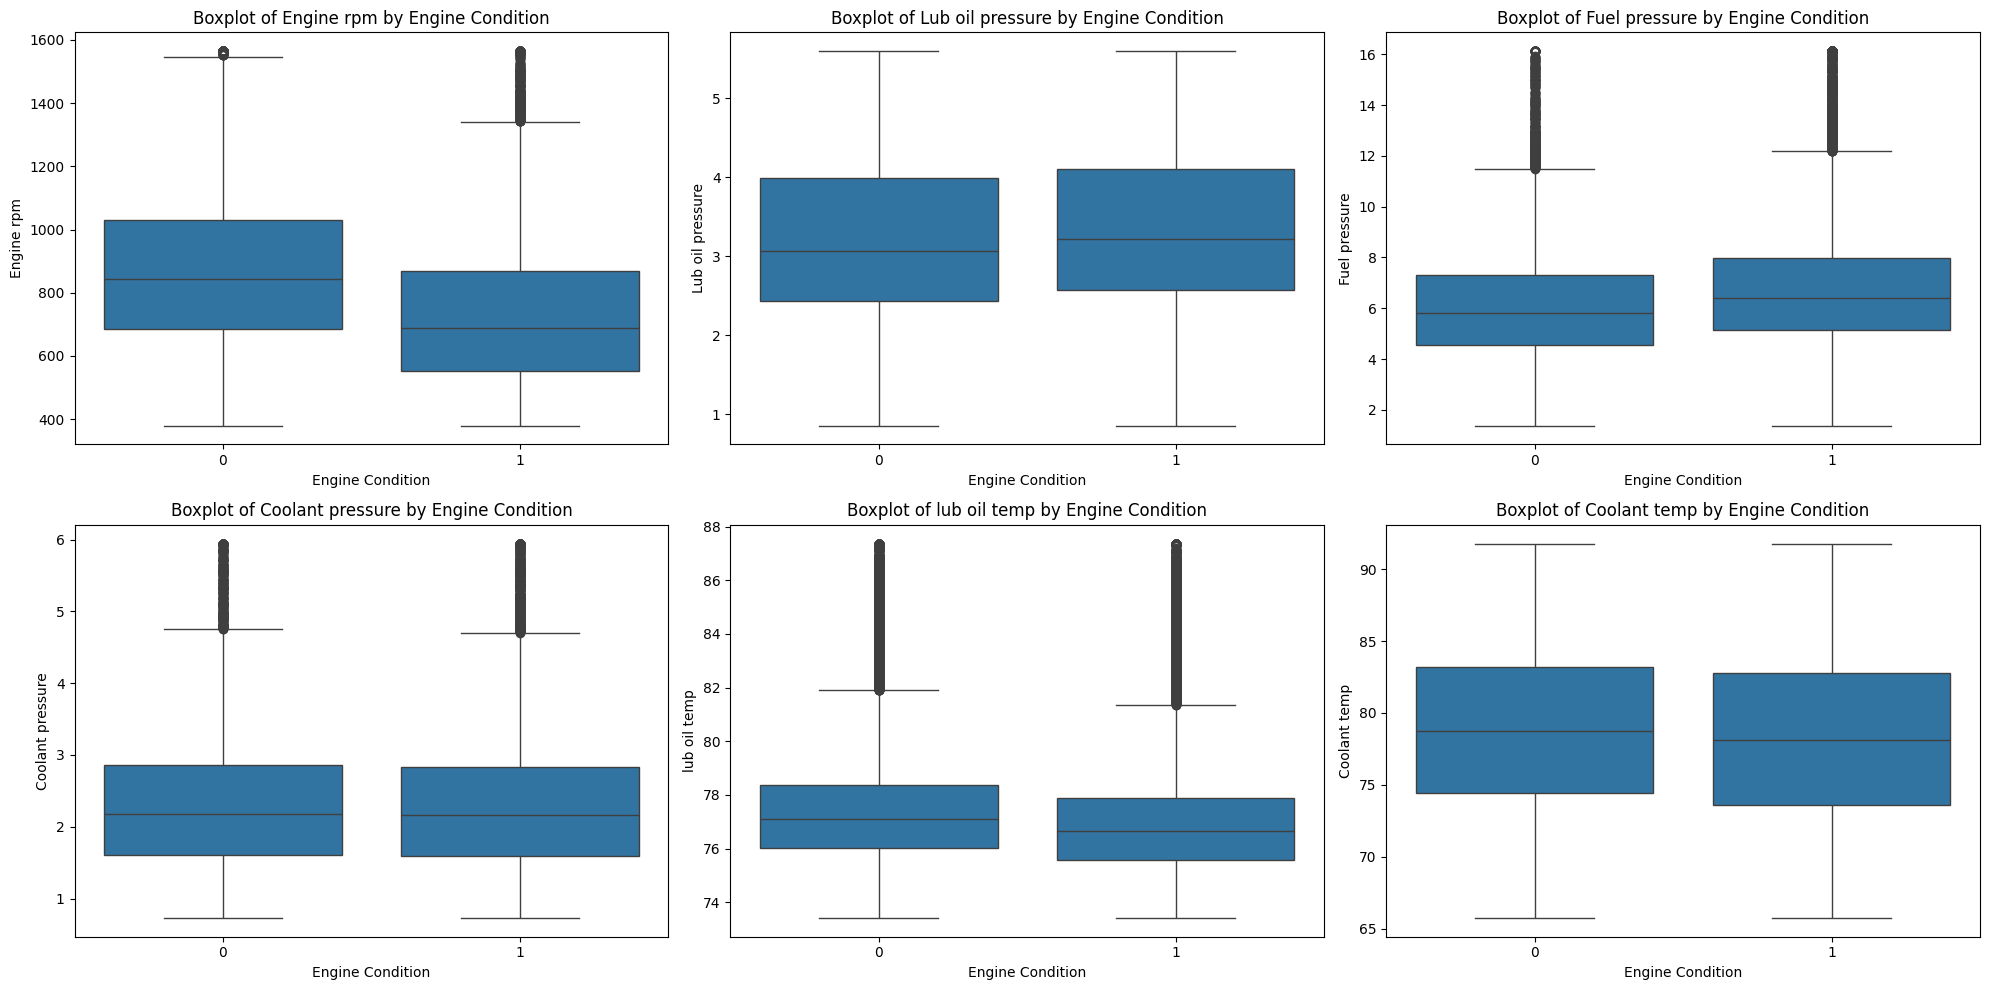

In [17]:
#outlier treatment

def cap_outliers(df_rounded, column):
    lower_percentile = df_rounded[column].quantile(0.01)
    upper_percentile = df_rounded[column].quantile(0.99)
    df_rounded[column] = np.where(df_rounded[column] < lower_percentile, lower_percentile, df_rounded[column])
    df_rounded[column] = np.where(df_rounded[column] > upper_percentile, upper_percentile, df_rounded[column])
    return df

# List of columns to treat
columns_to_treat = ['Engine rpm', 'Lub oil pressure', 'Fuel pressure', 
                    'Coolant pressure', 'lub oil temp', 'Coolant temp']

# Apply the cap_outliers function to each column
for column in columns_to_treat:
    df_rounded = cap_outliers(df_rounded, column)

# Now let's visualize the treated data
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
for i, column in enumerate(columns_to_treat, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Engine Condition', y=column, data=df_rounded)
    plt.title(f'Boxplot of {column} by Engine Condition')

plt.tight_layout()
plt.show()

In [18]:
#save the new data
output_file_path = 'data/treated_data.csv'
df.to_csv(output_file_path, index=False)
print(f"Treated data saved to {output_file_path}")

Treated data saved to data/treated_data.csv


In [19]:
#read the dataset
df2 = pd.read_csv('data/treated_data.csv')

In [20]:
df2.head()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Engine Condition
0,700.0,2.493592,11.790927,3.178981,84.144163,81.632187,1
1,876.0,2.941606,16.128895,2.464504,77.640934,82.445724,0
2,520.0,2.961746,6.553147,1.064347,77.752266,79.645777,1
3,473.0,3.707835,16.128895,3.727455,74.129907,71.774629,1
4,619.0,5.596747,15.738871,2.052251,78.396989,87.000225,0


In [21]:
#round off the values
df2_rounded = df2.round(2)

In [22]:
#spit the data
X = df2_rounded.drop("Engine Condition",axis=1)
y = df2_rounded['Engine Condition']

In [23]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Training individual models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [25]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [26]:
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [27]:
# Predictions and accuracy
y_pred_rf = rf_model.predict(X_test)
y_pred_dt = dt_model.predict(X_test)
y_pred_svm = svm_model.predict(X_test)

# Calculating accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

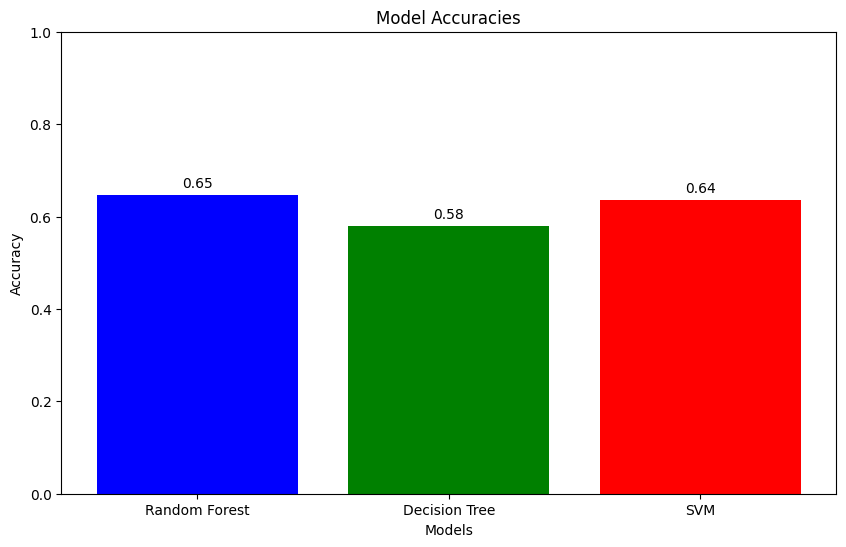

In [28]:
# Plotting accuracy of individual models
models = ['Random Forest', 'Decision Tree', 'SVM']
accuracies = [accuracy_rf, accuracy_dt, accuracy_svm]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')
plt.show()

In [29]:

# Normalizing the data
normalizer = MinMaxScaler()
X_train_normalized = normalizer.fit_transform(X_train)
X_test_normalized = normalizer.transform(X_test)

# Reshaping the data for CNN
X_train_cnn_normalized = X_train_normalized.reshape(X_train_normalized.shape[0], X_train_normalized.shape[1], 1)
X_test_cnn_normalized = X_test_normalized.reshape(X_test_normalized.shape[0], X_test_normalized.shape[1], 1)


In [30]:
# LSTM Model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_normalized.shape[1], 1)),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_normalized, y_train, epochs=60, batch_size=32)



Epoch 1/60


489/489 [==============================] - 3s 3ms/step - loss: 0.6582 - accuracy: 0.6314
Epoch 2/60
489/489 [==============================] - 1s 3ms/step - loss: 0.6393 - accuracy: 0.6372
Epoch 3/60
489/489 [==============================] - 1s 3ms/step - loss: 0.6292 - accuracy: 0.6433
Epoch 4/60
489/489 [==============================] - 1s 3ms/step - loss: 0.6181 - accuracy: 0.6479
Epoch 5/60
489/489 [==============================] - 1s 3ms/step - loss: 0.6117 - accuracy: 0.6573
Epoch 6/60
489/489 [==============================] - 2s 3ms/step - loss: 0.6094 - accuracy: 0.6573
Epoch 7/60
489/489 [==============================] - 1s 3ms/step - loss: 0.6065 - accuracy: 0.6637
Epoch 8/60
489/489 [==============================] - 1s 3ms/step - loss: 0.6077 - accuracy: 0.6608
Epoch 9/60
489/489 [==============================] - 1s 3ms/step - loss: 0.6076 - accuracy: 0.6607
Epoch 10/60
489/489 [==============================] - 1s 3ms/step - loss: 0.6054 - accuracy: 0.

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the model
rf = RandomForestClassifier()

# Initialize Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2)

# Fit the Grid Search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validated score: {best_score}")

# Train the model with the best parameters on the full training set
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy}")

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validated score: 0.671486723787647
Test set accuracy: 0.6580496544663424


In [33]:
best_params = {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

# Initialize the Random Forest model with the best parameters
best_rf = RandomForestClassifier(**best_params)

# Train the model
best_rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy}")

# Save the trained model
joblib.dump(best_rf, 'best_rf_model.joblib')
print("Model saved as best_rf_model.joblib")

Test set accuracy: 0.6542103916048119
Model saved as best_rf_model.joblib


In [35]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize the Decision Tree classifier
dt = DecisionTreeClassifier()

# Initialize Grid Search
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2)

# Fit the Grid Search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validated score: {best_score}")

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}
Best cross-validated score: 0.6472990236520358


In [36]:
# Train the Decision Tree model with the best parameters on the full training set
best_dt = grid_search.best_estimator_
best_dt.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_dt.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy}")

# Save the trained model
joblib.dump(best_dt, 'best_dt_model.joblib')
print("Model saved as best_dt_model.joblib")

Test set accuracy: 0.6296391092910161
Model saved as best_dt_model.joblib


In [37]:
# Define the parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4]  # This is relevant only for the 'poly' kernel
}

# Initialize the SVM classifier
svm = SVC()

# Initialize Grid Search
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2)

# Fit the Grid Search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validated score: {best_score}")

Fitting 3 folds for each of 96 candidates, totalling 288 fits


In [ ]:
# Train the SVM model with the best parameters on the full training set
best_svm = grid_search.best_estimator_
best_svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_svm.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy}")

# Save the trained model
joblib.dump(best_svm, 'best_svm_model.joblib')
print("Model saved as best_svm_model.joblib")

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate synthetic data with specific ranges for each feature
def generate_synthetic_data(n_samples=3000):
    # Use make_classification to generate base data
    X, y = make_classification(
        n_samples=n_samples,
        n_features=6,
        n_informative=4,
        n_redundant=1,
        n_repeated=0,
        n_classes=2,
        weights=[0.5, 0.5],
        class_sep=1.0,
        random_state=42
    )
    
    # Define realistic ranges for each feature
    X[:, 0] = np.abs(X[:, 0] * 500) + 500  # Engine rpm: [500, 1500]
    X[:, 1] = np.abs(X[:, 1] * 5) + 20     # Lub oil pressure: [20, 30]
    X[:, 2] = np.abs(X[:, 2] * 5) + 15     # Fuel pressure: [15, 25]
    X[:, 3] = np.abs(X[:, 3] * 2) + 1      # Coolant pressure: [1, 3]
    X[:, 4] = np.abs(X[:, 4] * 10) + 70    # lub oil temp: [70, 90]
    X[:, 5] = np.abs(X[:, 5] * 10) + 60    # Coolant temp: [60, 80]

    return X, y

X, y = generate_synthetic_data()

# Create a DataFrame with the generated data
feature_names = ['Engine rpm', 'Lub oil pressure', 'Fuel pressure', 'Coolant pressure', 'lub oil temp', 'Coolant temp']
df = pd.DataFrame(X, columns=feature_names)
df['Engine Condition'] = y

# Save the DataFrame to a CSV file
df.to_csv('newengine_data.csv', index=False)